In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from models.training import test

/home/zhdano82/.conda/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load surrogate model

The following script initializes a model and loads the dataset. Afterwards, the model is trained on the data. 
If the 'train' flag is 0, the model is not trained. Hence, keep it so unless you want to pretrain a surrogate model yourself. 

The pre-trained model is trained on samples with ids from 0 to 50000. The range of loaded data is defined by 'start_id' (first) and 'n_samples' (last).

In [2]:
%run scripts/train_surrogate.py --verbose 1 --start_id 50000 --n_samples 51000 --augmentation 0 --distance 'l2' --train 0 --in_shape 128 16 --n_layers 3 --n_epochs 1000 --batch_size 16 --model 'fcnet' --minmax 1 --log 1 --data_path '/bigdata/hplsim/aipp/Maksim/BA_simulation/layer_3/' --savedir 'saved_models/'

100%|██████████| 200/200 [00:00<00:00, 352.84it/s]



 Data loaders created


Let us now load a pre-trained surrogate model and test its performance on our training data. 

Note: if the range (start_id, n_samples) does not intersect with (0,50000), all the samples in the loaded dataset are unseen for the pre-trained model.

In [3]:
pt_name = 'fcnet___1_1_0_l1_3_128_16'
model.load_state_dict(torch.load('./saved_models/'+pt_name, map_location=device))

test_loss = test(loaders['train'], model)
print('Val MSE: {:.4f}'.format(test(loaders['train'], model)))

assert test_loss < 1e-2, "Test loss is too high. Please contact me (Maksim Zhdanov) in Mattermost."

Val MSE: 0.0023


### Visualize the simulation

Let us now visualize how the model is able to simulate GISAXS images.

In [4]:
xs, ys = next(iter(loaders['val']))
x_pred = model(ys.cuda()).cpu().detach()

In [5]:
grid_img = make_grid(xs.unsqueeze(1)[:9], nrow=3).cpu().detach()
grid_img_pred = make_grid(x_pred[:9], nrow=3).cpu().detach()

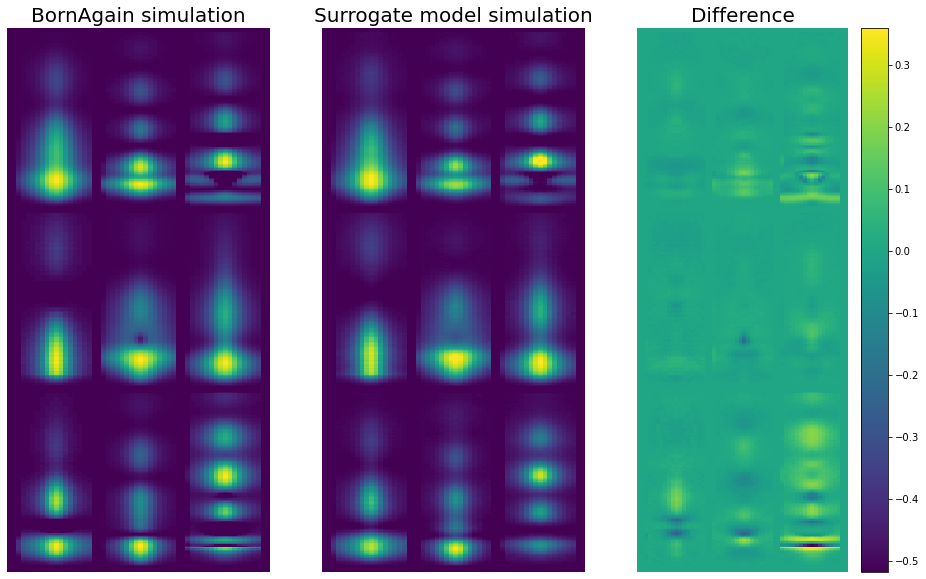

In [6]:
plt.figure(figsize=[16,10])

plt.subplot(1,3,1)
plt.title('BornAgain simulation', fontsize = 20)
plt.imshow(grid_img[0], vmin = 0, vmax = 1, aspect = 'auto', interpolation='nearest')
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Surrogate model simulation', fontsize = 20)
plt.imshow(grid_img_pred[0], vmin = 0, vmax = 1, aspect = 'auto', interpolation='nearest')
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Difference', fontsize = 20)
plt.imshow(grid_img[0] - grid_img_pred[0], aspect = 'auto', interpolation='nearest')
plt.axis('off')
plt.colorbar()